# Keras RCNN

In [1]:
%matplotlib inline

In [2]:
# import tensorflow.contrib.eager as tfe

# tfe.enable_eager_execution()

In [3]:
import os
import keras_rcnn

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from glob import glob
from skimage.io import imread

## Setup Paths

In [4]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'input')
stage_label = 'stage1'

In [5]:
train_path = os.path.join(DATA_DIR, '{}_train'.format(stage_label))
val_path = os.path.join(DATA_DIR,'{}_val'.format(stage_label))
test_path = os.path.join(DATA_DIR, '{}_test'.format(stage_label))

## Read Labels

In [6]:
train_labels = pd.read_csv(os.path.join(DATA_DIR,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
7395,3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba3994...,"[247657, 12, 248176, 15, 248695, 18, 249214, 2..."
1489,0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba6...,"[24943, 8, 25198, 11, 25213, 6, 25454, 23, 257..."
5507,2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f...,"[99530, 7, 100047, 11, 100565, 13, 101084, 15,..."


## Load Images

In [7]:
all_images = glob(os.path.join(DATA_DIR, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(5)

,path,ImageId,ImageType,TrainingSplit,Stage
15406,/src/workspace/data-science-bowl-2018/input/st...,20b20ab049372d184c705acebe7af026d3580f5fd5a72e...,masks,train,stage1
1395,/src/workspace/data-science-bowl-2018/input/st...,0bda515e370294ed94efd36bd53782288acacb040c171d...,masks,train,stage1
24835,/src/workspace/data-science-bowl-2018/input/st...,da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f66084...,masks,train,stage1
25102,/src/workspace/data-science-bowl-2018/input/st...,dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59...,masks,train,stage1
8770,/src/workspace/data-science-bowl-2018/input/st...,4e07a653352b30bb95b60ebc6c57afbc7215716224af73...,masks,train,stage1


## Create Training Data
Here we make training data and load all the images into the dataframe. We take a simplification here of grouping all the regions together (rather than keeping them distinct).

In [8]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['mask_paths'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['image_paths'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['image_paths'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
def read_and_stack_masks(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in 
                            enumerate(in_img_list,1)], 0), 0)
train_img_df['masks'] = train_img_df['mask_paths'].map(read_and_stack_masks).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 43.6 s, sys: 10.1 s, total: 53.7 s
Wall time: 55.7 s


## Show a Few Images

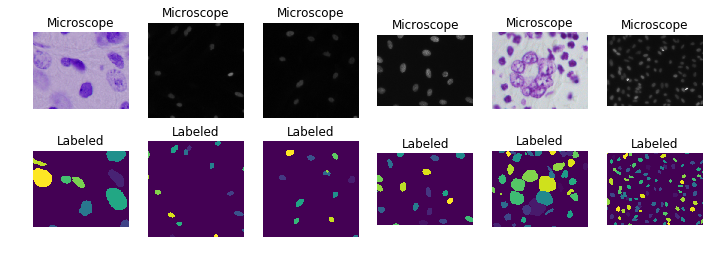

In [9]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

## Check Dimensions

In [10]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      322
(256, 320, 3)      104
(520, 696, 3)       90
(360, 360, 3)       85
(1024, 1024, 3)     15
(512, 640, 3)       12
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

In [11]:
train_img_df.sample(2)

,ImageId,Stage,image_paths,mask_paths,images,masks
118,2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb...,stage1,[/src/workspace/data-science-bowl-2018/input/s...,[/src/workspace/data-science-bowl-2018/input/s...,"[[[0.054901960784313725, 0.054901960784313725,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
626,fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4...,stage1,[/src/workspace/data-science-bowl-2018/input/s...,[/src/workspace/data-science-bowl-2018/input/s...,"[[[0.023529411764705882, 0.023529411764705882,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Create a Dictionary with Bounding Boxes
Reformat the data for bounding box style annotation

In [12]:
from skimage.morphology import label
from skimage.measure import regionprops

train_dict = [dict(image = dict(
    pathname = c_row['image_paths'][0],
                  shape =  dict(zip(['r', 'c', 'channels'], c_row['images'].shape))),
                   objects = [{'bounding_box' : dict(
                    minimum = dict(r = c_reg.bbox[0], c = c_reg.bbox[1]),
                   maximum = dict(r = c_reg.bbox[2], c = c_reg.bbox[3])),
                                  'class' : "nucleus",
                               'mask': dict(pathname = c_path)
                              }
                                   for c_reg, c_path in zip(
                                       regionprops(label(c_row['masks'])),
                                       c_row['mask_paths']
                                   )]
                  ) 
              for _, c_row in train_img_df.iterrows()]
print(str(train_dict[0])[:500])

{'image': {'pathname': '/src/workspace/data-science-bowl-2018/input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png', 'shape': {'r': 256, 'c': 256, 'channels': 3}}, 'objects': [{'bounding_box': {'minimum': {'r': 0, 'c': 188}, 'maximum': {'r': 8, 'c': 206}}, 'class': 'nucleus', 'mask': {'pathname': '/src/workspace/data-science-bowl-2018/input/stage1_train/00071198d059ba7f5914a526d124d28e6d010


## Data Generator

In [13]:
import keras.backend
import keras.preprocessing.image
import numpy
import skimage.io
import skimage.transform

def scale_size(size, min_size, max_size):
    """
    Rescales a given image size such that the larger axis is
    no larger than max_size and the smallest axis is as close
    as possible to min_size.
    """
    assert (len(size) == 2)

    scale = min_size / numpy.min(size)

    # Prevent the biggest axis from being larger than max_size.
    if numpy.round(scale * numpy.max(size)) > max_size:
        scale = max_size / numpy.max(size)

    rows, cols = size
    rows *= scale
    cols *= scale

    return (int(rows), int(cols)), scale


class DictionaryIterator(keras.preprocessing.image.Iterator):
    def __init__(
            self,
            dictionary,
            classes,
            generator,
            target_shape=None,
            scale=1,
            ox=None,
            oy=None,
            batch_size=1,
            shuffle=False,
            seed=None
    ):
        self.dictionary = dictionary
        self.classes = classes
        self.generator = generator

        r = dictionary[0]["image"]["shape"]["r"]
        c = dictionary[0]["image"]["shape"]["c"]

        channels = dictionary[0]["image"]["shape"]["channels"]

        self.image_shape = (r, c, channels)
        self.scale = scale
        self.ox = ox
        self.oy = oy

        self.batch_size = batch_size

        if target_shape is None:
            self.target_shape, self.scale = scale_size(self.image_shape[0:2], numpy.min(self.image_shape[:2]), numpy.max(self.image_shape[:2]))

            self.target_shape = self.target_shape + (self.image_shape[2],)

        else:
            self.target_shape = target_shape + (self.image_shape[2],)

        # Metadata needs to be computed only once.
        r, c, channels = self.target_shape

        self.target_metadata = numpy.array([[r, c, self.scale]])

        super(DictionaryIterator, self).__init__(len(self.dictionary), batch_size, shuffle, seed)

    def next(self):
        with self.lock:
            selection = next(self.index_generator)

        return self._get_batches_of_transformed_samples(selection)

    def _get_batches_of_transformed_samples(self, selection):
        # Labels has num_classes + 1 elements, since 0 is reserved for
        # background.
        num_classes = len(self.classes)

        target_bounding_boxes = numpy.zeros((self.batch_size, 0, 4), dtype=keras.backend.floatx())

        target_images = numpy.zeros((self.batch_size,) + self.target_shape, dtype=keras.backend.floatx())

        target_masks = numpy.zeros((self.batch_size,) + self.target_shape, dtype=keras.backend.floatx())

        target_scores = numpy.zeros((self.batch_size, 0, num_classes + 1), dtype=numpy.uint8)

        for batch_index, image_index in enumerate(selection):
            count = 0

            while count == 0:
                # Image
                target_image_pathname = self.dictionary[image_index]["image"]["pathname"]

                target_image = skimage.io.imread(target_image_pathname)[:, :, :3]

                if target_image.ndim == 2:
                    target_image = numpy.expand_dims(target_image, -1)

                # crop
                if self.ox is None:
                    offset_x = numpy.random.randint(0, self.image_shape[1] - self.target_shape[1] + 1)
                else:
                    offset_x = self.ox

                if self.oy is None:
                    offset_y = numpy.random.randint(0, self.image_shape[0] - self.target_shape[0] + 1)
                else:
                    offset_y = self.oy

                target_image = target_image[offset_y:self.target_shape[0] + offset_y, offset_x:self.target_shape[1] + offset_x, :]

                # Copy image to batch blob.
                target_images[batch_index] = skimage.transform.rescale(target_image, scale=self.scale, mode="reflect")

                # Set ground truth boxes.
                for object_index, b in enumerate(self.dictionary[image_index]["objects"]):
                    if b["class"] not in self.classes:
                        continue

                    bounding_box = b["bounding_box"]

                    minimum_c = bounding_box["minimum"]["c"] - offset_x
                    minimum_r = bounding_box["minimum"]["r"] - offset_y

                    maximum_c = bounding_box["maximum"]["c"] - offset_x
                    maximum_r = bounding_box["maximum"]["r"] - offset_y

                    if maximum_c == target_image.shape[1]:
                        maximum_c -= 1

                    if maximum_r == target_image.shape[0]:
                        maximum_r -= 1

                    if minimum_c >= 0 and maximum_c < target_image.shape[1] and minimum_r >= 0 and maximum_r < target_image.shape[0]:
                        count += 1

                        target_bounding_box = [
                            minimum_c,
                            minimum_r,
                            maximum_c,
                            maximum_r
                        ]

                        target_bounding_boxes = numpy.append(target_bounding_boxes, [[target_bounding_box]], axis=1)

                        target_score = [0] * (num_classes + 1)

                        target_score[self.classes[b["class"]]] = 1

                        target_scores = numpy.append(target_scores, [[target_score]], axis=1)

            # Scale the ground truth boxes to the selected image scale.
            target_bounding_boxes[batch_index, :, :4] *= self.scale

        return [target_bounding_boxes, target_images, target_masks, self.target_metadata, target_scores], None


class ImageSegmentationGenerator:
    def flow(self, dictionary, classes, target_shape=None, scale=None, ox=None, oy=None, batch_size=1, shuffle=True, seed=None):
        return DictionaryIterator(dictionary, classes, self, target_shape, scale, ox, oy, batch_size, shuffle, seed)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Check to see if it's loaded correctly

x 5
	 (1, 20, 4)
	 (1, 256, 256, 3)
	 (1, 256, 256, 3)
	 (1, 3)
	 (1, 20, 2)


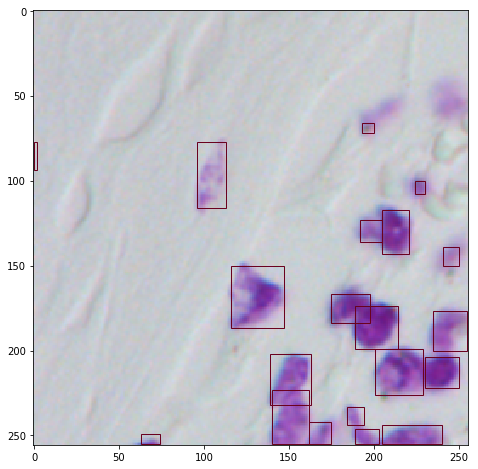

In [14]:
import matplotlib
seg_gen = ImageSegmentationGenerator().flow(train_dict, {'nucleus': 1})
x_out, _ = seg_gen.next()
print('x', len(x_out))
for x in x_out:
    print('\t', x.shape)

(target_bounding_boxes, target_image, _, _, target_scores) = x_out
target_bounding_boxes = np.squeeze(target_bounding_boxes)
target_image = np.squeeze(target_image)
target_scores = np.argmax(target_scores, -1)
target_scores = np.squeeze(target_scores)

_, axis = plt.subplots(1, figsize=(12, 8))
axis.imshow(target_image)

for target_index, target_score in enumerate(target_scores):
    if target_score > 0:
        xy = [
            target_bounding_boxes[target_index][0],
            target_bounding_boxes[target_index][1]
        ]

        w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
        h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]

        rectangle = matplotlib.patches.Rectangle(xy, w, h, 
                                                 edgecolor=plt.cm.RdBu(target_score), 
                                                 facecolor="none")
        axis.add_patch(rectangle)

matplotlib.pyplot.show()

In [15]:
import keras
from keras.layers import Input
from keras_rcnn.models import RCNN

img_in = Input((None, None, 3))
rcnn_model = RCNN(img_in, ['nuclei'])
optimizer = keras.optimizers.Adam(0.0001)
rcnn_model.compile(optimizer)
print('Input:', rcnn_model.get_input_shape_at(0))
print('Output:', rcnn_model.get_output_shape_at(0))
#rcnn_model.summary()

TypeError: `Tensor` objects are not iterable when eager execution is not enabled. To iterate over this tensor use `tf.map_fn`.